In [1]:
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from utils.conn_data import load_pickle

plt.style.use('ggplot')

In [4]:
outputs_path = os.path.join(os.getcwd(), 'data', 'outputs')

## Simulation 1

### Dataset

For each covariance in a list of different covariances between graph pairs, we simulate 30 times (n_simulations) a list of 50 (n_graphs) pairs of graphs from the erdos-renyi family of graphs. For each pair of graph, we sample a random variable p from a multivariate gaussian distribution with fixed mean and covariance.

### Model

1) $\textbf{Spectrum}$: For each pair of graphs, compute the spectral radii for each adjacency matrix individually, and compute the Spearman's rank correlation between the spectral radiis for each graph.

2) $\textbf{SDNE}$: For each epoch, for each pair of graphs, compute the embeddings using the SDNE (autoencoder), and compute the Spearman's rank correlation between the vectorial version of the embeddings of each graph.


In [41]:
dataset = "simulation1"
models = os.listdir(os.path.join(outputs_path, dataset))
all_test_data = []
agg_metrics = []
all_metrics_by_true_cov = []
all_diff_by_true_cov = []
for model in models:

    # print(model)

    # load data
    data = load_pickle(os.path.join(outputs_path, dataset, model, 'results.pkl'))

    if model == 'spectrum':
        test_data = data["train_test_results"]
    else:
        test_data = data["test_results"]

    test_data_df = []
    for i in range(test_data.shape[0]):
        simulation_test_data = test_data[i, :, :]
        simulation_test_data_df = pd.DataFrame(simulation_test_data.numpy(), columns=["pred", "true"])
        simulation_test_data_df["simulation"] = i

        test_data_df.append(simulation_test_data_df)
    test_data_df = pd.concat(test_data_df, axis=0)
    test_data_df["true"] = [round(x, 2) for x in test_data_df["true"]]
    test_data_df["model"] = model
    all_test_data.append(test_data_df)

    # compute aggregated mse and mae
    mse = mean_squared_error(test_data_df["true"], test_data_df["pred"])
    mae = mean_absolute_error(test_data_df["true"], test_data_df["pred"])
    agg_metrics.append({"model": model, "mse": mse, "mae": mae})

    # compute mse and mae per true cov
    metrics_by_true_cov = []
    for cov in test_data_df["true"].unique():
        selected_df = test_data_df.loc[test_data_df["true"] == cov]

        pred = selected_df["pred"]
        true = selected_df["true"]

        mse = mean_squared_error(true, pred)
        mae = mean_absolute_error(true, pred)
        metrics_by_true_cov.append({"model": model, "dataset": dataset, "cov": cov, "mse": mse, "mae": mae})
    metrics_by_true_cov_df = pd.DataFrame(metrics_by_true_cov)
    all_metrics_by_true_cov.append(metrics_by_true_cov_df)

    # compute diff by true cov
    diff_by_true_cov = []
    for cov in test_data_df["true"].unique():
        selected_df = test_data_df.loc[test_data_df["true"] == cov]

        pred = selected_df["pred"]
        true = selected_df["true"]

        selected_df.loc[:, "diff"] = true - pred
        diff_by_true_cov.append(selected_df)
    diff_by_true_cov_df = pd.concat(diff_by_true_cov, axis=0)
    all_diff_by_true_cov.append(diff_by_true_cov_df)

all_test_data_df = pd.concat(all_test_data, axis=0)
agg_metrics_df = pd.DataFrame(agg_metrics)
all_metrics_by_true_cov_df = pd.concat(all_metrics_by_true_cov, axis=0)
all_diff_by_true_cov_df = pd.concat(all_diff_by_true_cov, axis=0)

/Users/danieloliveira/opt/anaconda3/envs/gce/lib/python3.10/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/danieloliveira/opt/anaconda3/envs/gce/lib/python3.10/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/danieloliveira/opt/anaconda3/envs/gce/lib/python3.10/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [28]:
agg_metrics_df.sort_values(by="mse")

,model,mse,mae
7,spectrum,0.012207,0.080875
3,sdne_50_1_1,0.230635,0.414673
4,sdne_100_1_1,0.239547,0.421662
8,sdne_30_1_1,0.262872,0.442059
0,sdne_100_5_5,0.263724,0.445030
6,sdne_40_1_1,0.314047,0.465510
9,sdne_20_1_1,0.327944,0.477572
2,sdne_100_10_10,0.329946,0.498067
5,sdne_100_15_15,0.347070,0.506616
1,sdne_100_20_20,0.361367,0.512059


In [42]:
all_diff_by_true_cov_df

,pred,true,simulation,model,diff
0,-0.144659,-1.0,0,sdne_100_5_5,-0.855341
0,-0.162581,-1.0,1,sdne_100_5_5,-0.837419
0,-0.153917,-1.0,2,sdne_100_5_5,-0.846083
0,-0.165319,-1.0,3,sdne_100_5_5,-0.834681
0,-0.157644,-1.0,4,sdne_100_5_5,-0.842356
...,...,...,...,...,...
19,0.345492,0.9,25,sdne_20_1_1,0.554508
19,0.392069,0.9,26,sdne_20_1_1,0.507931
19,0.342714,0.9,27,sdne_20_1_1,0.557286
19,0.342144,0.9,28,sdne_20_1_1,0.557856


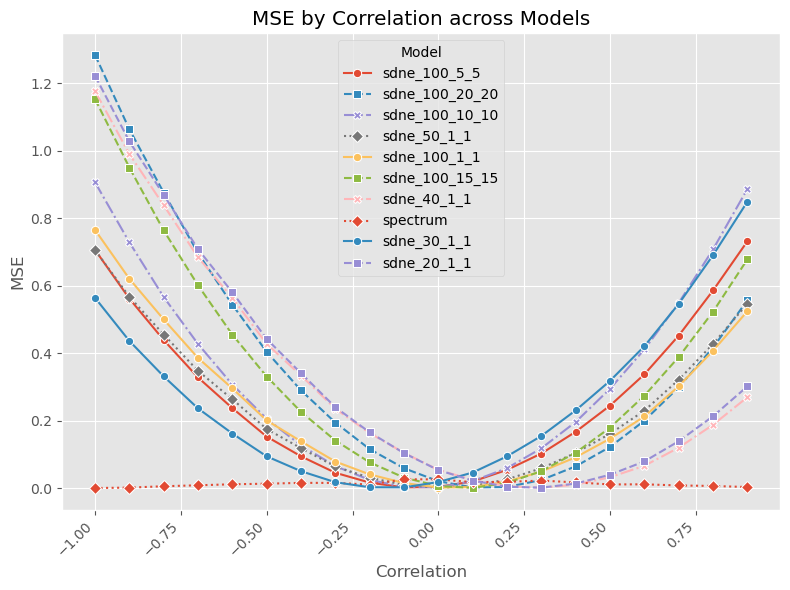

In [37]:
# Define unique line styles and markers for each model, ensure there are enough styles for each model
styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'X', 'D']

plt.figure(figsize=(8, 6))  # Create a figure for the plots

# Get the unique models
unique_models = all_metrics_by_true_cov_df["model"].unique()

# Iterate through each unique model and plot on the same graph with a unique style
for idx, model in enumerate(unique_models):
    # Filter the DataFrame for the current model
    model_df = all_metrics_by_true_cov_df[all_metrics_by_true_cov_df["model"] == model]
    
    # Plot the lineplot on the same figure with unique style and marker
    sns.lineplot(
        x='cov', y='mse', data=model_df,
        label=model, linestyle=styles[idx % len(styles)], marker=markers[idx % len(markers)]
    )

plt.title('MSE by Correlation across Models')  # Set the title for the entire plot
plt.xlabel('Correlation')  # Set the x-axis label
plt.ylabel('MSE')  # Set the y-axis label
plt.legend(title='Model')  # Enable the legend to distinguish models

# Rotate x labels for better fit
plt.xticks(rotation=45, ha='right')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

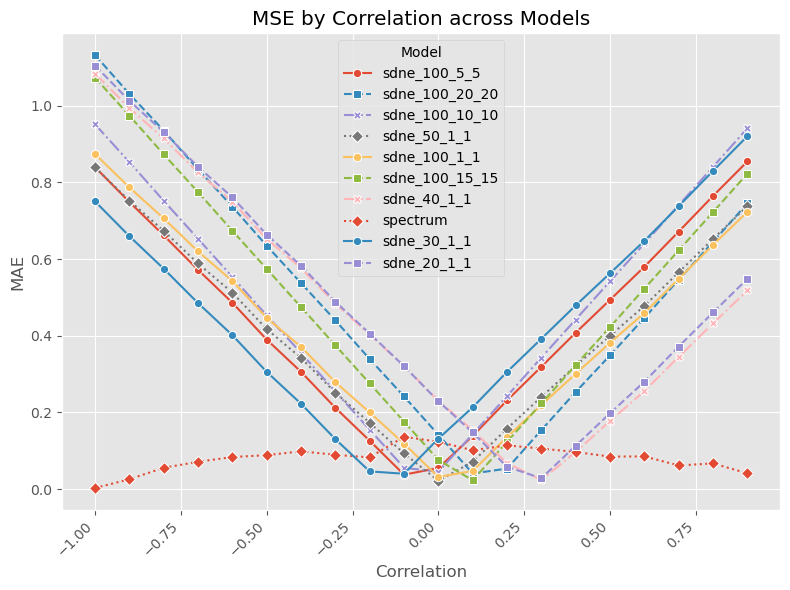

In [38]:
# Define unique line styles and markers for each model, ensure there are enough styles for each model
styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'X', 'D']

plt.figure(figsize=(8, 6))  # Create a figure for the plots

# Get the unique models
unique_models = all_metrics_by_true_cov_df["model"].unique()

# Iterate through each unique model and plot on the same graph with a unique style
for idx, model in enumerate(unique_models):
    # Filter the DataFrame for the current model
    model_df = all_metrics_by_true_cov_df[all_metrics_by_true_cov_df["model"] == model]
    
    # Plot the lineplot on the same figure with unique style and marker
    sns.lineplot(
        x='cov', y='mae', data=model_df,
        label=model, linestyle=styles[idx % len(styles)], marker=markers[idx % len(markers)]
    )

plt.title('MSE by Correlation across Models')  # Set the title for the entire plot
plt.xlabel('Correlation')  # Set the x-axis label
plt.ylabel('MAE')  # Set the y-axis label
plt.legend(title='Model')  # Enable the legend to distinguish models

# Rotate x labels for better fit
plt.xticks(rotation=45, ha='right')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

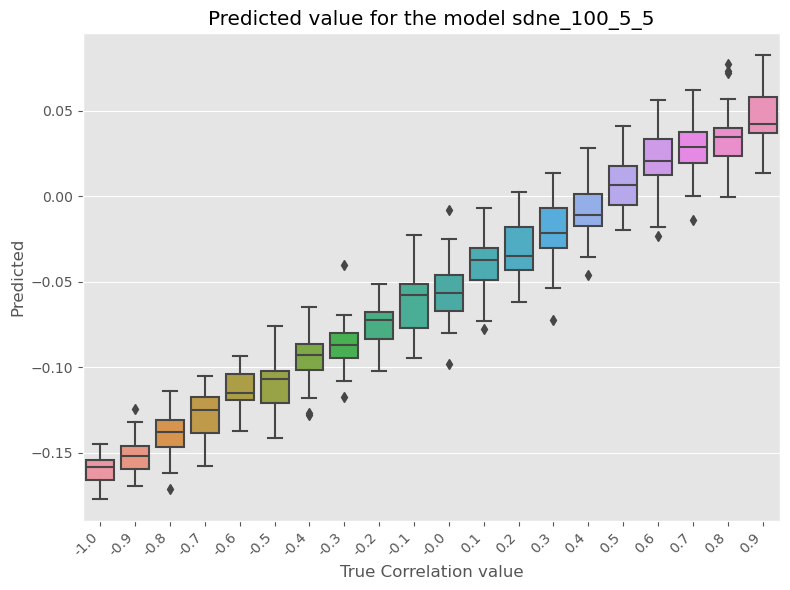

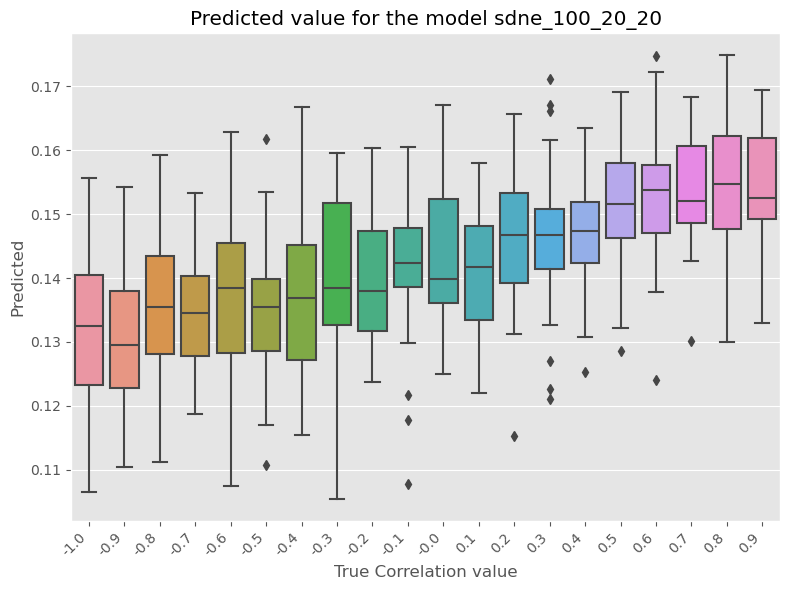

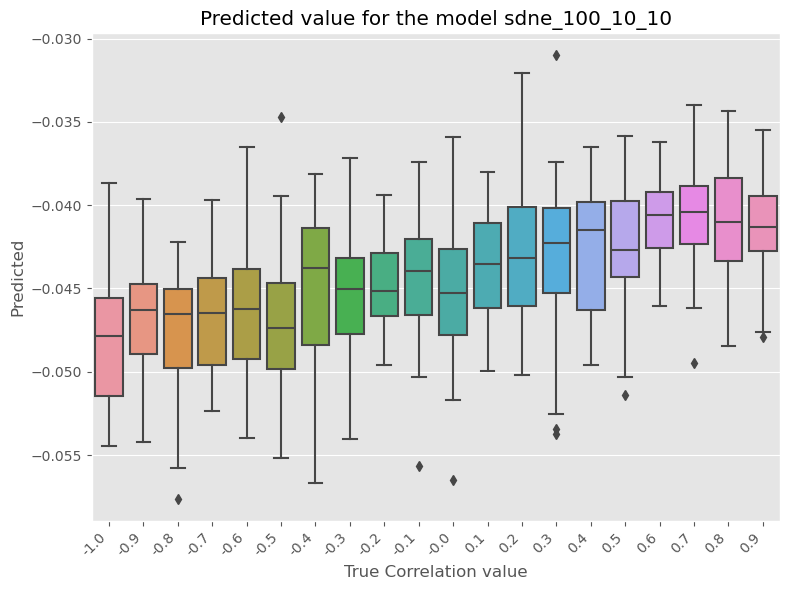

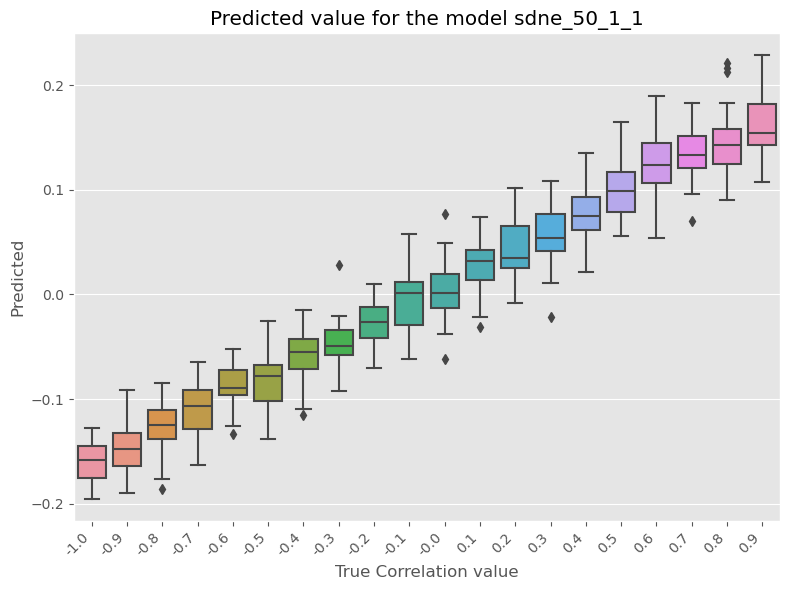

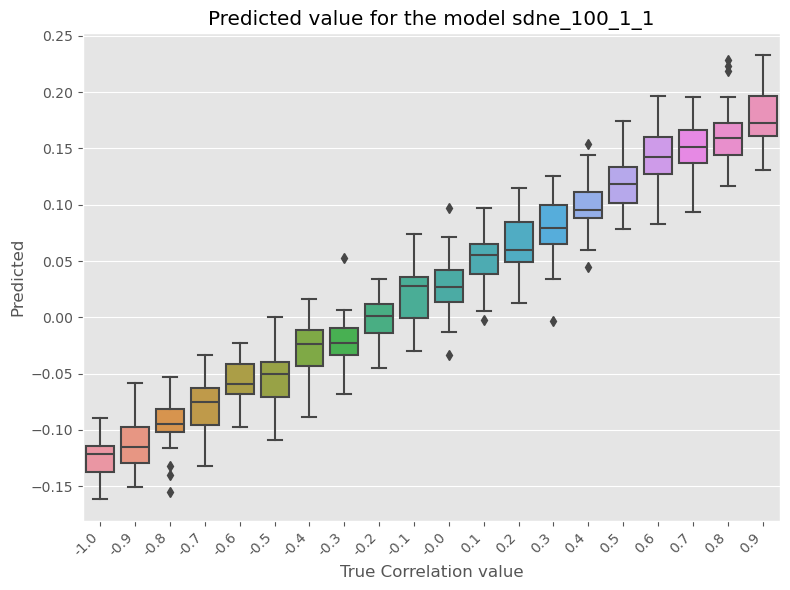

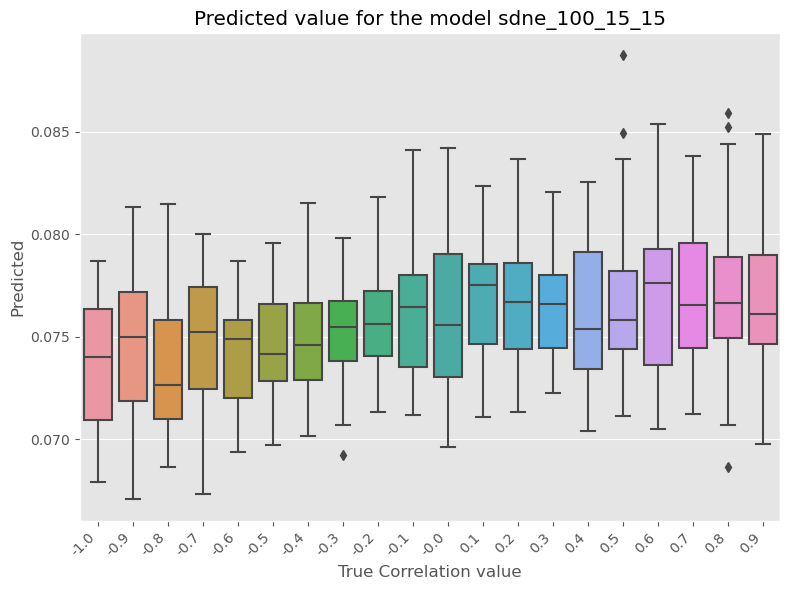

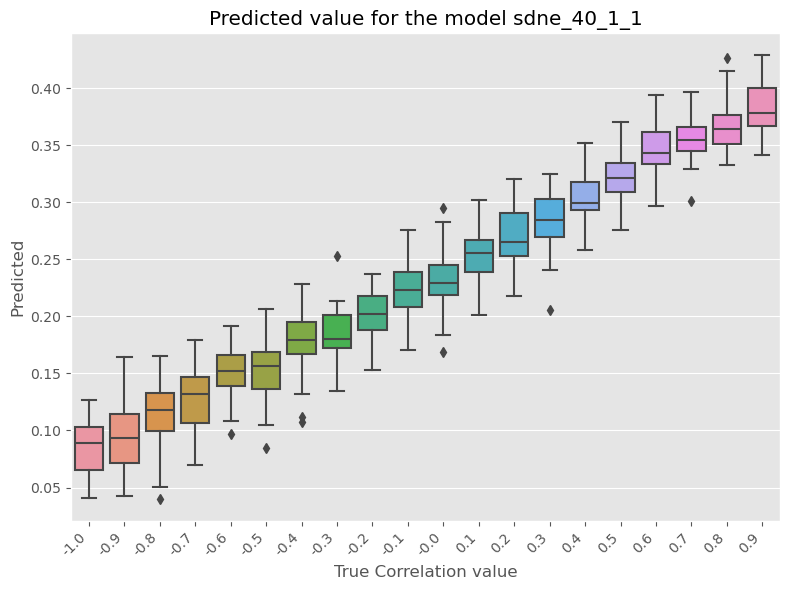

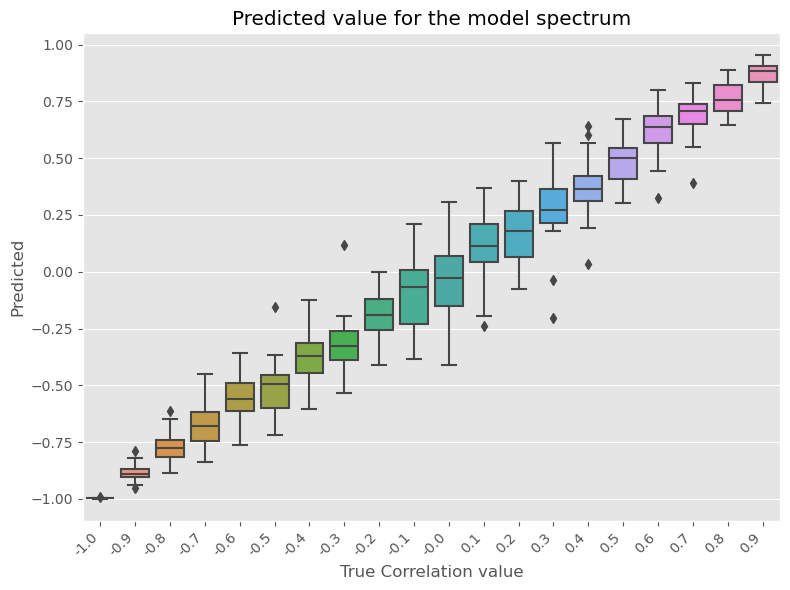

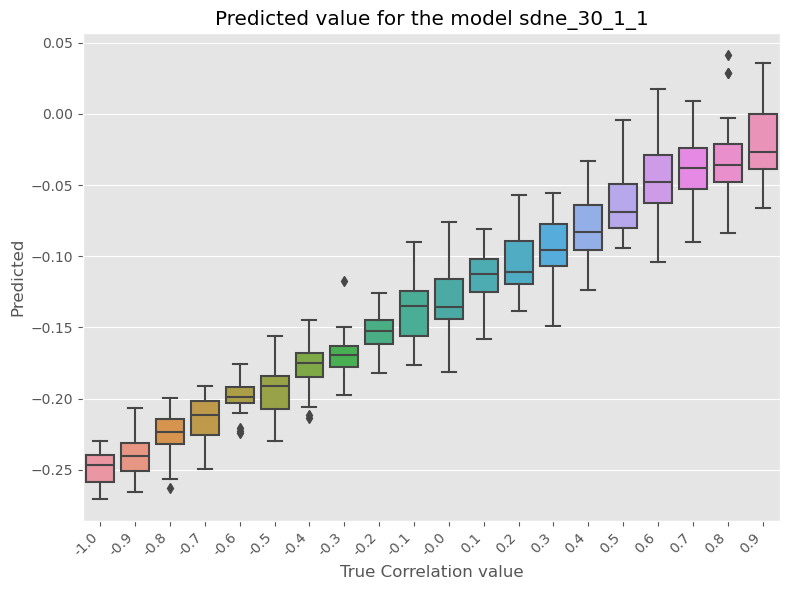

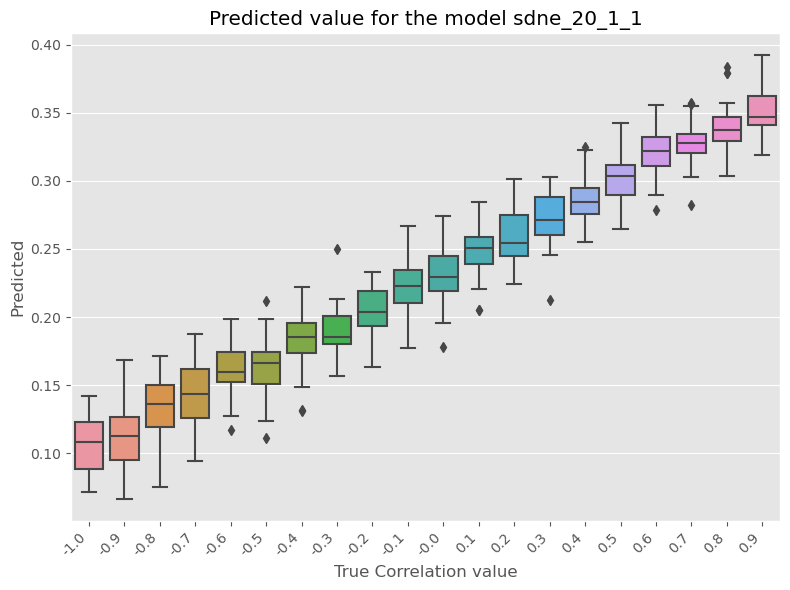

In [46]:
for model in all_diff_by_true_cov_df["model"].unique():
    model_df = all_diff_by_true_cov_df[all_diff_by_true_cov_df["model"] == model]
    plt.figure(figsize=(8, 6))
    sns.boxplot(x="true", y="pred", data=model_df)
    plt.title(f'Predicted value for the model {model}')
    plt.xlabel('True Correlation value')
    plt.ylabel('Predicted')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Simulation 1a

### Dataset

For each covariance in a list of different covariances between graph pairs, for n in a list of the number of nodes (10 to 100, 10 by 10), we simulate 30 times (n_simulations) a list of 50 (n_graphs) pairs of graphs from the erdos-renyi family of graphs. For each pair of graph, we sample a random variable p from a multivariate gaussian distribution with fixed mean and covariance.

In [6]:
models_ovrd = ["spectrum"]

prediction_error_e1a = []
dataset = 'simulation1a'
for model in models_ovrd:

    # list dirs path
    n_nodes = os.listdir(os.path.join(outputs_path, dataset))
    for n in n_nodes:

        # load data
        data = load_pickle(os.path.join(outputs_path, dataset, n, model, 'results.pkl'))


        try:
            pred_df = pd.DataFrame({"pred": data['pred'], "true": data["true"]}).dropna()
        except:
            pred_df = pd.DataFrame({"pred": data['test_pred'], "true": data["test_true"]}).dropna()

        # compute relevant metrics
        mse = mean_squared_error(pred_df['true'], pred_df['pred'])
        mae = mean_absolute_error(pred_df['true'], pred_df['pred'])

        # store results
        prediction_error_e1a.append({"model": model, "dataset": dataset, "n_nodes": n, "mse": mse, "mae": mae})
prediction_error_e1a_df = pd.DataFrame(prediction_error_e1a)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/danieloliveira/Documents/Daniel/codes/graph-corr-embedd/src/data/outputs/simulation1a/10/spectrum/results.pkl'

## MSE as a function of the number of nodes

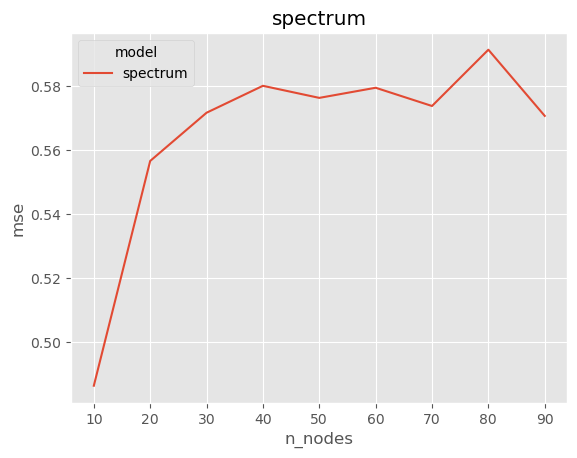

In [8]:
prediction_error_e1a_df

for model in models_ovrd:

    tmp_prediction_df = prediction_error_e1a_df[prediction_error_e1a_df['model'] == model]
    tmp_prediction_df = tmp_prediction_df.sort_values(by=['n_nodes'], ascending=True)
    # line plot of the mse column as a function of the number of nodes
    plt.title(f'{model}')
    sns.lineplot(x="n_nodes", y="mse", data=tmp_prediction_df, hue="model")